In [1]:
import numpy as np
import math
import torch
from torch import nn
from torch import functional as F
import scipy.stats as stats
import matplotlib
import matplotlib.pyplot as plt
from livelossplot import PlotLosses
from Inference.Variational import MeanFieldVariationalDistribution
from Inference.VariationalBoosting import MeanFieldVariationalMixtureDistribution
from Tools.NNtools import *

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [3]:
# load data and make it in proper shape
data = torch.load('data/foong_data.pt')
x_data = data[0].to(device)
y_data = data[1].to(device)
y_data = y_data.unsqueeze(-1)

In [4]:
model = nn.Sequential( nn.Linear(1, 20),
                       nn.Tanh(), 
                       nn.Linear(20, 1),
                     ).to(device)

In [5]:
param_count = get_param(model).shape[0]

In [6]:
flip_parameters_to_tensors(model)

In [7]:
prior = MeanFieldVariationalDistribution(param_count, sigma=1.0, device=device)
prior.mu.requires_grad = False
prior.rho.requires_grad = False

In [8]:
def logprior(x):
    return prior.log_prob(x)

In [9]:
def loglikelihood(theta, model, x, y, sigma_noise):
    def _log_norm(x, mu, std):
        return -0.5 * torch.log(2*np.pi*std**2) -(0.5 * (1/(std**2))* (x-mu)**2)
    #set_param(model, theta)
    set_all_parameters(model, theta)
    y_pred = model(x)
    L = _log_norm(y_pred, y, torch.tensor([sigma_noise],device=device))
    return torch.sum(L).unsqueeze(-1)

In [10]:
def logposterior(theta, model, x, y, sigma_noise):
    return logprior(theta) + loglikelihood(theta, model, x, y, sigma_noise)

In [11]:
def show_variational_posterior_predictive(q):
    x_test = torch.linspace(-2.0, 2.0).unsqueeze(1).to(device)
    # Sampling the distribution over Neural Networks 1000 times, and plotting with transparency to make it appear as a smooth distribution
    fig, ax = plt.subplots()
    fig.set_size_inches(11.7, 8.27)
    plt.xlim(-2, 2) 
    plt.ylim(-4, 4) 
    plt.scatter(x_data.cpu(), y_data.cpu())
    for _ in range(1000):
        z = q.sample()
        set_all_parameters(model, z)
        y_test = model(x_test)

        plt.plot(x_test.detach().cpu().numpy(), y_test.squeeze(0).detach().cpu().numpy(), alpha=0.05, linewidth=1, color='lightblue')

In [12]:
def MAP():
    theta = torch.nn.Parameter( prior.sample(), requires_grad=True)

    optimizer = torch.optim.Adam([theta], lr=0.1)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.8)

    for t in range(10000):
        optimizer.zero_grad()

        L = -torch.mean(logposterior(theta, model, x_data, y_data, sigma_noise=0.1))
        L.backward()

        learning_rate = optimizer.param_groups[0]['lr']

        scheduler.step(L.detach().clone().cpu().numpy())
        optimizer.step()

        if learning_rate < 0.001:
            break
    return theta.detach().clone()

In [337]:
def MetropolisHastings(theta, T):
    theta_proposal = theta_current + torch.empty([1,param_count], device=device).normal_(std=0.003*T**0.5)
    p_proposal = logposterior(theta_proposal, model, x_data, y_data, 0.1)
    p_current = logposterior(theta_current, model, x_data, y_data, 0.1)

    A = p_proposal/T - p_current/T
    
    if torch.distributions.uniform.Uniform(0.0,1.0).sample().log() < A.cpu():
        return theta_proposal, 1
    else:
        return theta_current, 0

In [14]:
MAP_pool = []
for j in range(10):
    MAP_pool.append(MAP())

In [915]:
nb_iter = 2000

In [916]:
Ladder = [0.5, 1, 1.5, 2, 3, 5, 10, 20, 40, 120, 500]

In [917]:
Chain = [0]*len(Ladder)

In [918]:
ChainTrack = [[i] for i in range(len(Ladder))]

In [919]:
for i in range(len(Chain)):
    Chain[i] = [prior.sample()]

In [920]:
SwapAcceptanceRate = [0]*(len(Ladder)-1)
LadderAcceptance = [0]*(len(Ladder))

In [921]:
LogProbaMatrix = []
for i in range(len(Ladder)):
    LogProbaMatrix.append([[]])
for  j in range(len(Ladder)):
    LogProbaMatrix[j] = [logposterior(Chain[j][-1], model, x_data, y_data, 0.1 )]

In [922]:
import time
start = time.time()

%matplotlib inline
liveloss = PlotLosses()
for t in range(nb_iter):
    with torch.no_grad():
        for j in range(len(Ladder)):
            theta_current = Chain[j][t]
            T = Ladder[j]
            theta_current, accept = MetropolisHastings(theta_current, T)
            Chain[j].append(theta_current)
            ChainTrack[j].append(ChainTrack[j][-1])
            if accept:
                LadderAcceptance[j] = LadderAcceptance[j]+1

        # Compute the current logprobability of all chains. 
        for  j in range(len(Ladder)):
            LogProbaMatrix[j].append(logposterior(Chain[j][-1], model, x_data, y_data, 0.1 ))
        
        #j = np.random.randint(0,len(Ladder)-1)

        for j in np.random.permutation(len(Ladder)-1):
            #theta_left = Chain[j][-1]
            #theta_right = Chain[j+1][-1]
            T_left = Ladder[j]
            T_right = Ladder[j+1]

            logA = LogProbaMatrix[j][-1]/T_right + LogProbaMatrix[j+1][-1]/T_left \
                 - LogProbaMatrix[j][-1]/T_left - LogProbaMatrix[j+1][-1]/T_right

            A = torch.exp(logA).cpu()

            if torch.distributions.uniform.Uniform(0.0,1.0).sample() < A:
                tmp = Chain[j][-1]
                Chain[j][-1] = Chain[j+1][-1]
                Chain[j+1][-1] = tmp

                tmp = ChainTrack[j][-1]
                ChainTrack[j][-1] = ChainTrack[j+1][-1]
                ChainTrack[j+1][-1] = tmp

                SwapAcceptanceRate[j] = SwapAcceptanceRate[j]+1
            
end = time.time()
print(end - start)          

219.03472757339478


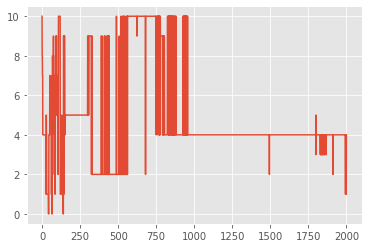

In [927]:
plt.plot(ChainTrack[-1])

In [928]:
torch.tensor(SwapAcceptanceRate).float()/t

tensor([0.0660, 0.0260, 0.2831, 0.3327, 0.3132, 0.2301, 0.3362, 0.3867, 0.3032,
        0.1061])

In [929]:
torch.tensor(LadderAcceptance).float()/t

tensor([0.4062, 0.4447, 0.4292, 0.4572, 0.4632, 0.4357, 0.4072, 0.3957, 0.3927,
        0.3932, 0.3892])

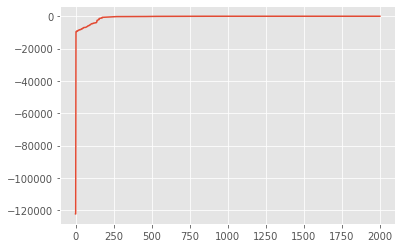

In [930]:
plt.plot(torch.stack(LogProbaMatrix[0][1:]).squeeze(-1).squeeze(-1).detach().clone().cpu().numpy())

In [935]:
S = torch.cat(Chain[-1], dim=0)

In [936]:
S.shape

torch.Size([2001, 61])

In [937]:
samples = S[1000:2000:1,:]

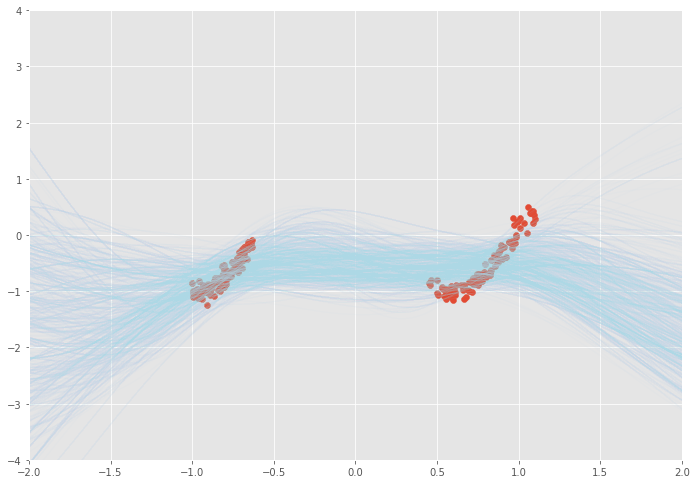

In [938]:
x_test = torch.linspace(-2.0, 2.0).unsqueeze(1).to(device)
# Sampling the distribution over Neural Networks 1000 times, and plotting with transparency to make it appear as a smooth distribution
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
plt.xlim(-2, 2) 
plt.ylim(-4, 4) 
plt.scatter(x_data.cpu(), y_data.cpu())
for i in range(samples.shape[0]):
    z = samples[i,:].unsqueeze(0)
    set_all_parameters(model, z)
    y_test = model(x_test)

    plt.plot(x_test.detach().cpu().numpy(), y_test.squeeze(0).detach().cpu().numpy(), alpha=0.05, linewidth=1, color='lightblue')

In [ ]:
Theta = torch.cat(samples,dim=0)

In [ ]:
from sklearn.metrics.pairwise import euclidean_distances

In [ ]:
D = euclidean_distances( Theta.detach().clone().cpu().numpy() ,  Theta.detach().clone().cpu().numpy() )

In [ ]:
%matplotlib inline
fig, ax = plt.subplots()
fig.set_size_inches(11.7*1.5, 8.27*1.5)
plt.imshow(D)